In [1]:
from glue_v2 import glue

In [2]:
from config_v2 import NAMES_OF_CLASSES, CLASSES
from croper_v2 import extract_crops
from applicator_v2 import generate

In [3]:
import os

def pths_iterator():
    base_path = './sam_improved_data/sam_data/'

    for image_name in os.listdir(base_path):
        image_dir_path = os.path.join(base_path, image_name)
        if 'image' in image_name:
            ip = os.path.join(image_dir_path, 'image.jpeg')
            mpd = {i: os.path.join(image_dir_path, f'mask_{i + 1}.png') for i in CLASSES}
            
            yield ip, mpd

In [4]:
extraction_info = pths_iterator()
backs_info = {ip: mpd for ip, mpd in pths_iterator()}

generate(
    extraction_info, # итератор для изображений, из которых будут выреезаться объекты
    backs_info, # словарь для изображений фона, на который будут вклеиваться объкты

    save_path='./check_classes_balance', # папка, куда сохранять сгенерированные изображения
    generated_objects_number=1500, # количество изображений, которые надо сгенерировать
    iters_in_class=[3, 3, 4, 3, 1, 1], # количество объеектов из каждого класса, которые нужно вклееить в один фон

    crop_size_for_hist_extraction=100, # размер области, по которой будет оценииваться похожесть фона.
    th=0.5 # трешхолд по маске, если маска не бинарная
)

/Users/eduard/Desktop/dissertation/laplaciangenerator/applicator_v2.py:36: RuntimeWarning: overflow encountered in power
  irf = np.e**(-1 / (1 - rgrid + eps))
/Users/eduard/Desktop/dissertation/laplaciangenerator/applicator_v2.py:44: RuntimeWarning: overflow encountered in power
  icf = np.e**(-1 / (1 - cgrid + eps))


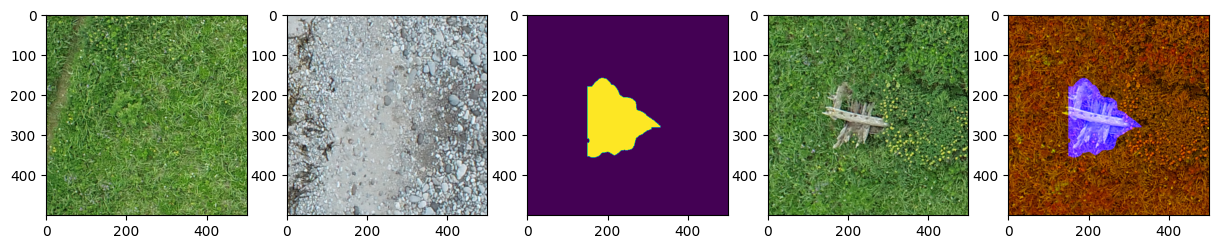

In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

path = '/Users/eduard/Desktop/dissertation/generator_tool_v2/for_disser/class_3'
mask_pathes = []

for d in os.listdir(path):
    if '570' in d:
        cur_path = os.path.join(path, d)
        for dd in os.listdir(cur_path):
            if '570' in dd:
                mask_pathes.append(os.path.join(cur_path, dd))
                
mask_parts = {
    mp.split('#')[1]: np.asarray(Image.open(mp))
    for mp in mask_pathes
}

img = np.asarray(Image.open('/Users/eduard/Desktop/dissertation/generator_tool_v2/for_disser/DJI_0570.jpeg'))

mask = np.concatenate([
    np.concatenate([mask_parts['lu'], mask_parts['cu'], mask_parts['ru']], axis=1),
    np.concatenate([mask_parts['lc'], mask_parts['cc'], mask_parts['rc']], axis=1),
    np.concatenate([mask_parts['ru'], mask_parts['rc'], mask_parts['rd']], axis=1)
], axis=0)

fig, axes = plt.subplots(ncols=5, figsize=(15, 15))

back_crop_1 = img[1500:2000, 1250:1750] / 255
back_crop_2 = img[1500:2000, 4250:4750] / 255
mask_crop = (mask[2500:3000, 1250:1750] > 0) * 1.
img_crop = img[2500:3000, 1250:1750] / 255
img_crop_and_mask = np.concatenate([img_crop[:, :, 1:], mask_crop[:, :, None]], axis=-1)

axes[0].imshow(back_crop_1)
axes[1].imshow(back_crop_2)
axes[2].imshow(mask_crop)
axes[3].imshow(img_crop)
axes[4].imshow(img_crop_and_mask);

In [5]:
n_layers = 10
sigma = 8

gaussian_mask, laplacian_background, laplacian_object, result_pyramid, pyramid_blend =\
glue(img_crop, mask_crop, back_crop_2, sigma, n_layers)

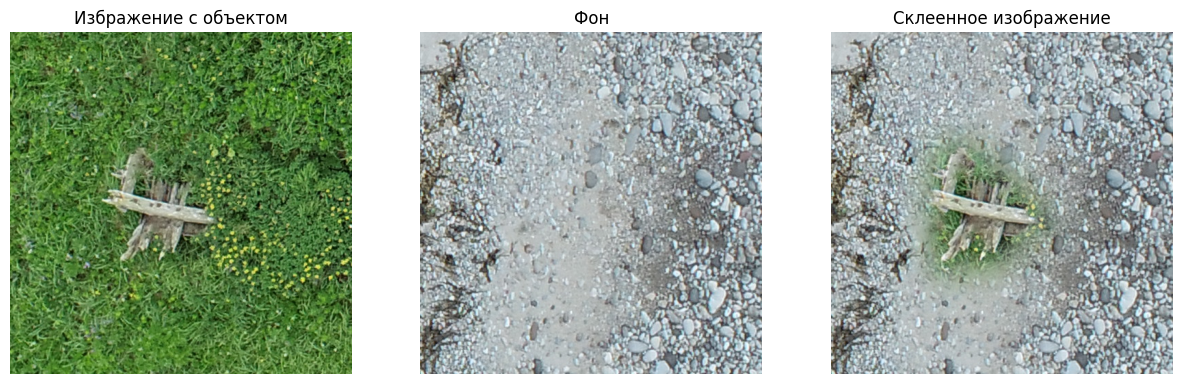

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 15))



axes[0].imshow(img_crop)
axes[0].set_title('Избражение с объектом')
axes[1].imshow(back_crop_2)
axes[1].set_title('Фон')
axes[2].imshow(pyramid_blend)
axes[2].set_title('Склеенное изображение')


axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off');

In [5]:
extraction_info = pths_iterator()
crops = extract_crops(extraction_info)

In [6]:
from config_v2 import INVERSE_CLASSES_MAP
INVERSE_CLASSES_MAP

{0: 'Железо',
 1: 'Рыболовные снасти',
 2: 'Пластик',
 3: 'Дерево',
 4: 'Бетон',
 5: 'Резина'}

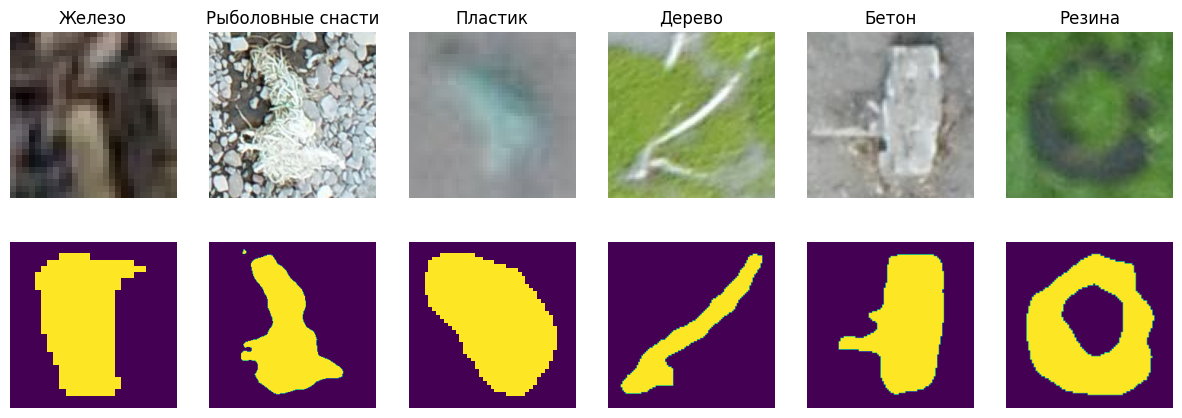

In [126]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=len(CLASSES), nrows=2, figsize=(15, 5))
for i in CLASSES:
    rand_number = np.random.randint(0, len(crops[i]))
    mc = crops[i][rand_number]['mask_crop']
    ic = crops[i][rand_number]['image_crop']
    
    axes[0, i].set_title(INVERSE_CLASSES_MAP[i])
    axes[0, i].imshow(ic)
    axes[1, i].imshow(mc)
    
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    
plt.show()

In [127]:
from applicator_v2 import get_random_crop
from croper_v2 import get_crop

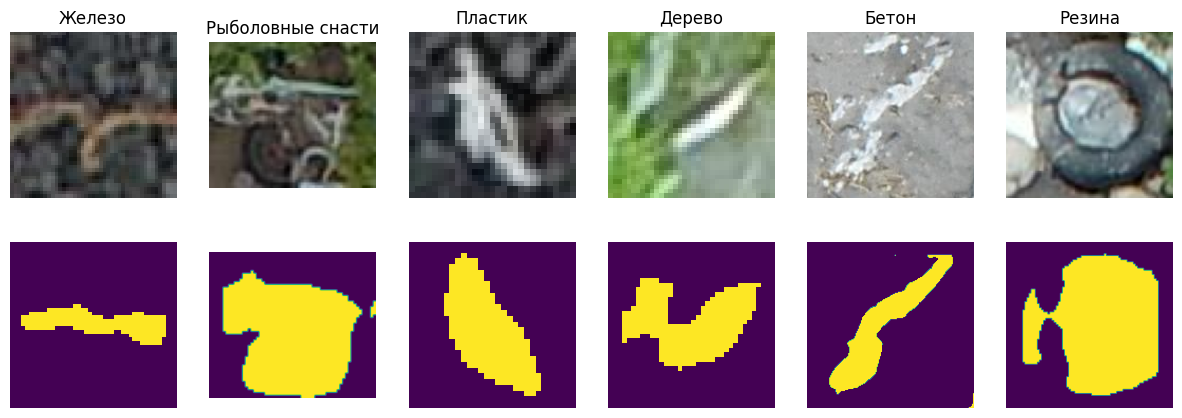

In [144]:
import numpy as np
import matplotlib.pyplot as plt

imgs = []
masks = []
fig, axes = plt.subplots(ncols=len(CLASSES), nrows=2, figsize=(15, 5))
for i in CLASSES:
    rand_number = np.random.randint(0, len(crops[i]))
    mc = crops[i][rand_number]['mask_crop']
    ic = crops[i][rand_number]['image_crop']
    
    imgs.append(ic)
    masks.append(mc)
    
    axes[0, i].set_title(INVERSE_CLASSES_MAP[i])
    axes[0, i].imshow(ic)
    axes[1, i].imshow(mc)
    
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    
plt.show()

In [145]:
crop_size = 100
r, c, hist = get_random_crop((back_crop_1 * 255).astype(np.uint8), crop_size)
crop = get_crop(back_crop_2, (r, r + crop_size), (c,  c + crop_size))

In [146]:
hists = []
for ic, mc in zip(imgs, crops):
    color_hist = np.concatenate([
        np.histogram(ic[:, :, 0][mc < 50], bins=np.arange(0, 256), density=True)[0], 
        np.histogram(ic[:, :, 1][mc < 50], bins=np.arange(0, 256), density=True)[0],
        np.histogram(ic[:, :, 2][mc < 50], bins=np.arange(0, 256), density=True)[0]
    ]) / 3
    
    color_hist = np.clip(color_hist, a_min=1e-10, a_max=np.inf)
    hists.append(color_hist)

3.3519171076141547
0.7357053073050861
1.9546458578435064
4.2092221137294095
7.8521425600741175
0.29587943578694725


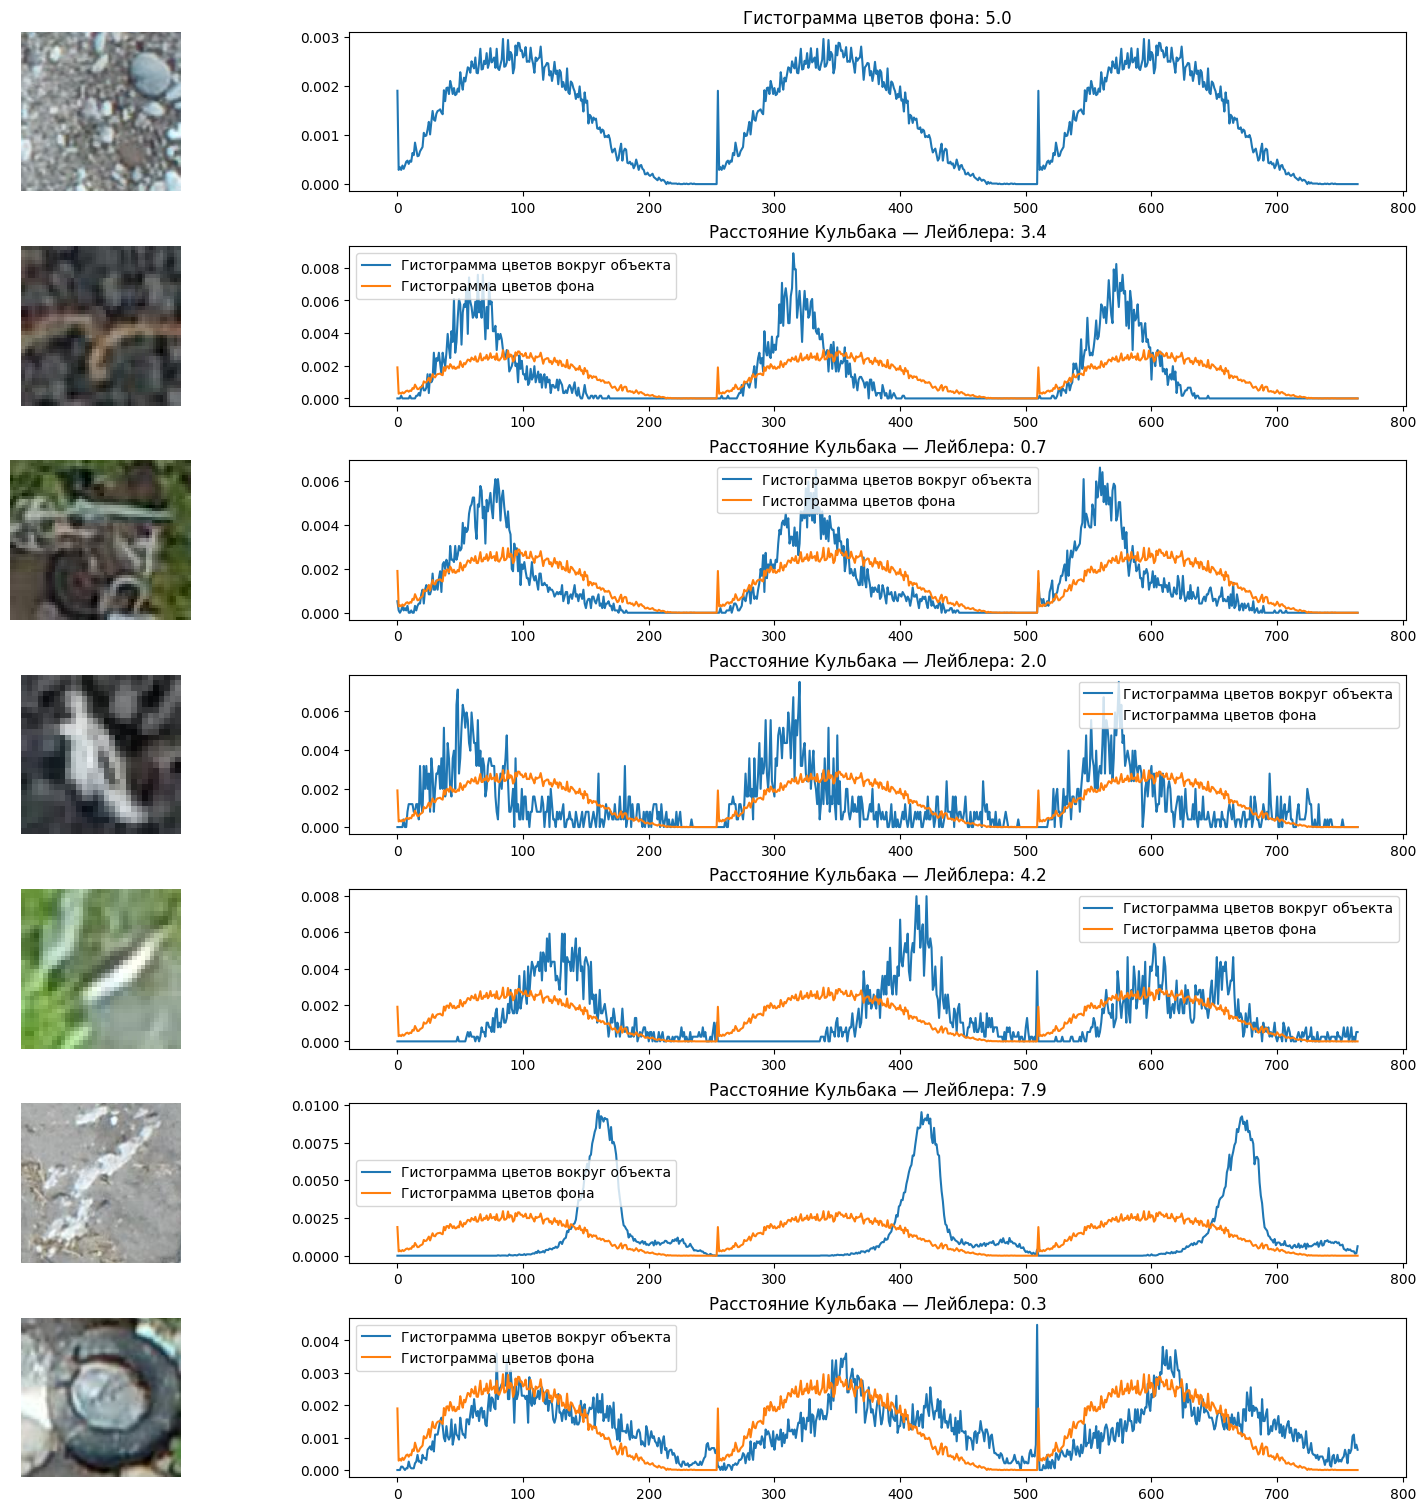

In [147]:
from scipy.special import rel_entr
fig, axes = plt.subplots(ncols=2, 
                         nrows=7, 
                         gridspec_kw={'width_ratios': [1, 3]}, 
                         figsize=(15, 15), 
                         constrained_layout = True)

axes[0, 0].imshow(crop)
axes[0, 0].axis('off')

axes[0, 1].plot(hist)
axes[0, 1].set_title(f'Гистограмма цветов фона: {round(ce, 1)}')

for i, (ic, h) in enumerate(zip(imgs, hists)):
    ce = np.sum(rel_entr(hist, h))
    print(ce)
        
    axes[i+1, 0].imshow(ic)
    axes[i+1, 0].axis('off')
    axes[i+1, 1].plot(h, label='Гистограмма цветов вокруг объекта')
    axes[i+1, 1].plot(hist, label='Гистограмма цветов фона')
    axes[i+1, 1].set_title(f'Расстояние Кульбака — Лейблера: {round(ce, 1)}')
    axes[i+1, 1].legend()